# Train a custom object detection model with TensorFlow Lite Model Maker

In this colab notebook, we use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) to train a custom object detection model to detect cars parked in outdoor parking lots and similar places.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

This notebook is based on the [Object Detection with TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker/object_detection) tutorial.


## Preparation

### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [1]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '__init__.cpython-37.pyc'
Consider using the `--user` option or check the permissions.



Import the required packages.

In [2]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2024-02-21 01:31:03.389907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-21 01:31:03.389968: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find th

### Prepare the dataset

This dataset contains about 78 images of different pakings with a total of 755 labeled instances of cars.

![sample parking with cars](images/test/Montreal_2022-6-30_17h0m.jpg)

We start with uploading the dataset to the notebook.

#### Convert JSON labels to unified CSV

Each training, validation and test image is accompanied with a JSON file that contains all the labels and their corresponding bounding box. However, the data loader used by TFlite, uses a unified CSV to load all images and data. The following script achieve this.

In [3]:
import os
import pandas as pd
import json

# Initialize empty DataFrame to store data
df_all = pd.DataFrame()

# Wrapper
def read_transform(json_dir, set_type):
    global df_all
    # Loop over JSON files in directory
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            # Load JSON file
            with open(os.path.join(json_dir, filename)) as f:
                data = json.load(f)
            # Extract relevant fields
            #print(data)
            imagePath = json_dir+'/'+data['imagePath']
            imageHeight = data['imageHeight']
            imageWidth = data['imageWidth']
            res = [{'set_type': set_type, 'imagePath': imagePath, 'label': shape['label'], 'p1x': shape['points'][0][0]/imageWidth, 'p1y': shape['points'][0][1]/imageHeight, 'p2x': '', 'p2y': '', 'p3x': shape['points'][1][0]/imageWidth, 'p3y': shape['points'][1][1]/imageHeight, 'p4x': '', 'p4y': ''} for shape in data['shapes']]
            #print(res[0])
            # Convert JSON to DataFrame
            df = pd.json_normalize(res)
            # Concatenate DataFrame to df_all
            df_all = pd.concat([df_all, df], ignore_index=True)

# Set directory containing JSON files
# Which set to assign the contents in the rows to
# See https://cloud.google.com/vision/automl/object-detection/docs/csv-format
# For training
json_dir = 'images/train'
set_type = 'TRAIN'
read_transform(json_dir, set_type)
# For validation
json_dir = 'images/validation'
set_type = 'VALIDATION'
read_transform(json_dir, set_type)
# For test
json_dir = 'images/test'
set_type = 'TEST'
read_transform(json_dir, set_type)
# Write concatenated DataFrame to CSV file
json_dir = 'images/'
df_all.to_csv(os.path.join(json_dir, 'all_data_automl.csv'), index=False, header=False)
print('done writting '+str(df_all.shape))


done writting (597, 11)


## Train the object detection model

### Step 1: Load the dataset

* Images in `train_data` is used to train the custom object detection model.
* Images in `validation_data` is used to check if the model can generalize well to new images that it hasn't seen before.
* Images in `test_data` are used to evaluate the model performance once trained.

In [4]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('images/all_data.csv')

### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite4 to train our model.

In [5]:
spec = model_spec.get('efficientdet_lite4')

2024-02-13 19:17:31.610797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-02-13 19:17:31.610863: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-13 19:17:31.610890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (test-vision): /proc/driver/nvidia/version does not exist
2024-02-13 19:17:31.661130: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [6]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=validation_data)

Epoch 1/20


2024-02-13 19:18:38.195426: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - ETA: 0s - det_loss: 2.0052 - cls_loss: 1.1270 - box_loss: 0.0176 - reg_l2_loss: 0.1078 - loss: 2.1130 - learning_rate: 0.0067 - gradient_norm: 0.9753 

2024-02-13 19:22:39.275078: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 252s 18s/step - det_loss: 2.0265 - cls_loss: 1.1266 - box_loss: 0.0180 - reg_l2_loss: 0.1078 - loss: 2.1343 - learning_rate: 0.0065 - gradient_norm: 1.0188 - val_det_loss: 1.7142 - val_cls_loss: 1.0764 - val_box_loss: 0.0128 - val_reg_l2_loss: 0.1078 - val_loss: 1.8219
Epoch 2/20
10/10 [==============================] - ETA: 0s - det_loss: 1.8941 - cls_loss: 1.0210 - box_loss: 0.0175 - reg_l2_loss: 0.1078 - loss: 2.0018 - learning_rate: 0.0049 - gradient_norm: 1.5451 

2024-02-13 19:25:30.759721: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 166s 17s/step - det_loss: 1.8558 - cls_loss: 1.0129 - box_loss: 0.0169 - reg_l2_loss: 0.1078 - loss: 1.9636 - learning_rate: 0.0049 - gradient_norm: 1.5285 - val_det_loss: 1.5358 - val_cls_loss: 0.9363 - val_box_loss: 0.0120 - val_reg_l2_loss: 0.1078 - val_loss: 1.6436
Epoch 3/20
10/10 [==============================] - ETA: 0s - det_loss: 1.6930 - cls_loss: 0.7912 - box_loss: 0.0180 - reg_l2_loss: 0.1078 - loss: 1.8007 - learning_rate: 0.0048 - gradient_norm: 3.6397 

2024-02-13 19:28:18.394989: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 169s 17s/step - det_loss: 1.6971 - cls_loss: 0.7686 - box_loss: 0.0186 - reg_l2_loss: 0.1078 - loss: 1.8049 - learning_rate: 0.0048 - gradient_norm: 3.6170 - val_det_loss: 1.2853 - val_cls_loss: 0.7184 - val_box_loss: 0.0113 - val_reg_l2_loss: 0.1078 - val_loss: 1.3931
Epoch 4/20
10/10 [==============================] - ETA: 0s - det_loss: 1.2709 - cls_loss: 0.5800 - box_loss: 0.0138 - reg_l2_loss: 0.1078 - loss: 1.3787 - learning_rate: 0.0046 - gradient_norm: 3.4101 

2024-02-13 19:31:03.539190: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 164s 17s/step - det_loss: 1.2354 - cls_loss: 0.5591 - box_loss: 0.0135 - reg_l2_loss: 0.1078 - loss: 1.3432 - learning_rate: 0.0046 - gradient_norm: 3.2316 - val_det_loss: 1.0897 - val_cls_loss: 0.5849 - val_box_loss: 0.0101 - val_reg_l2_loss: 0.1078 - val_loss: 1.1975
Epoch 5/20
10/10 [==============================] - ETA: 0s - det_loss: 1.4777 - cls_loss: 0.5957 - box_loss: 0.0176 - reg_l2_loss: 0.1078 - loss: 1.5855 - learning_rate: 0.0044 - gradient_norm: 3.2831 

2024-02-13 19:33:46.986855: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 177s 18s/step - det_loss: 1.4208 - cls_loss: 0.5855 - box_loss: 0.0167 - reg_l2_loss: 0.1078 - loss: 1.5286 - learning_rate: 0.0043 - gradient_norm: 3.1504 - val_det_loss: 1.0141 - val_cls_loss: 0.5655 - val_box_loss: 0.0090 - val_reg_l2_loss: 0.1078 - val_loss: 1.1219
Epoch 6/20
10/10 [==============================] - ETA: 0s - det_loss: 0.9400 - cls_loss: 0.4317 - box_loss: 0.0102 - reg_l2_loss: 0.1078 - loss: 1.0478 - learning_rate: 0.0041 - gradient_norm: 2.8970 

2024-02-13 19:36:44.663731: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 167s 17s/step - det_loss: 0.9510 - cls_loss: 0.4458 - box_loss: 0.0101 - reg_l2_loss: 0.1078 - loss: 1.0588 - learning_rate: 0.0040 - gradient_norm: 3.2043 - val_det_loss: 0.9059 - val_cls_loss: 0.4940 - val_box_loss: 0.0082 - val_reg_l2_loss: 0.1078 - val_loss: 1.0137
Epoch 7/20
10/10 [==============================] - ETA: 0s - det_loss: 0.8512 - cls_loss: 0.3872 - box_loss: 0.0093 - reg_l2_loss: 0.1078 - loss: 0.9590 - learning_rate: 0.0037 - gradient_norm: 2.4560 

2024-02-13 19:39:34.117784: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 169s 17s/step - det_loss: 0.8494 - cls_loss: 0.3949 - box_loss: 0.0091 - reg_l2_loss: 0.1078 - loss: 0.9572 - learning_rate: 0.0037 - gradient_norm: 2.3758 - val_det_loss: 0.7652 - val_cls_loss: 0.3997 - val_box_loss: 0.0073 - val_reg_l2_loss: 0.1078 - val_loss: 0.8730
Epoch 8/20
10/10 [==============================] - ETA: 0s - det_loss: 0.8179 - cls_loss: 0.3568 - box_loss: 0.0092 - reg_l2_loss: 0.1078 - loss: 0.9257 - learning_rate: 0.0033 - gradient_norm: 2.2170 

2024-02-13 19:42:20.111723: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 164s 16s/step - det_loss: 0.8138 - cls_loss: 0.3552 - box_loss: 0.0092 - reg_l2_loss: 0.1078 - loss: 0.9216 - learning_rate: 0.0033 - gradient_norm: 2.2253 - val_det_loss: 0.6845 - val_cls_loss: 0.3459 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.1078 - val_loss: 0.7923
Epoch 9/20
10/10 [==============================] - ETA: 0s - det_loss: 0.9096 - cls_loss: 0.3594 - box_loss: 0.0110 - reg_l2_loss: 0.1078 - loss: 1.0174 - learning_rate: 0.0029 - gradient_norm: 3.1558 

2024-02-13 19:45:02.159569: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 164s 17s/step - det_loss: 0.8858 - cls_loss: 0.3529 - box_loss: 0.0107 - reg_l2_loss: 0.1078 - loss: 0.9936 - learning_rate: 0.0029 - gradient_norm: 3.1736 - val_det_loss: 0.6426 - val_cls_loss: 0.3277 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.1078 - val_loss: 0.7504
Epoch 10/20
10/10 [==============================] - ETA: 0s - det_loss: 0.7303 - cls_loss: 0.3158 - box_loss: 0.0083 - reg_l2_loss: 0.1078 - loss: 0.8381 - learning_rate: 0.0025 - gradient_norm: 2.5590 

2024-02-13 19:47:41.310484: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 164s 17s/step - det_loss: 0.7651 - cls_loss: 0.3169 - box_loss: 0.0090 - reg_l2_loss: 0.1078 - loss: 0.8729 - learning_rate: 0.0025 - gradient_norm: 2.6072 - val_det_loss: 0.6178 - val_cls_loss: 0.3122 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.1078 - val_loss: 0.7256
Epoch 11/20
10/10 [==============================] - ETA: 0s - det_loss: 0.6238 - cls_loss: 0.2840 - box_loss: 0.0068 - reg_l2_loss: 0.1078 - loss: 0.7316 - learning_rate: 0.0021 - gradient_norm: 2.3230 

2024-02-13 19:50:26.235952: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 160s 16s/step - det_loss: 0.6088 - cls_loss: 0.2797 - box_loss: 0.0066 - reg_l2_loss: 0.1078 - loss: 0.7166 - learning_rate: 0.0021 - gradient_norm: 2.3177 - val_det_loss: 0.5749 - val_cls_loss: 0.2864 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.1078 - val_loss: 0.6827
Epoch 12/20
10/10 [==============================] - ETA: 0s - det_loss: 0.6590 - cls_loss: 0.2946 - box_loss: 0.0073 - reg_l2_loss: 0.1078 - loss: 0.7668 - learning_rate: 0.0017 - gradient_norm: 2.7089 

2024-02-13 19:53:06.141901: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 160s 16s/step - det_loss: 0.6737 - cls_loss: 0.2969 - box_loss: 0.0075 - reg_l2_loss: 0.1078 - loss: 0.7815 - learning_rate: 0.0017 - gradient_norm: 2.6405 - val_det_loss: 0.5690 - val_cls_loss: 0.2870 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.1078 - val_loss: 0.6768
Epoch 13/20
10/10 [==============================] - ETA: 0s - det_loss: 1.0946 - cls_loss: 0.3589 - box_loss: 0.0147 - reg_l2_loss: 0.1078 - loss: 1.2024 - learning_rate: 0.0013 - gradient_norm: 3.3480 

2024-02-13 19:55:41.837876: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 157s 16s/step - det_loss: 1.0659 - cls_loss: 0.3527 - box_loss: 0.0143 - reg_l2_loss: 0.1078 - loss: 1.1737 - learning_rate: 0.0013 - gradient_norm: 3.2376 - val_det_loss: 0.5988 - val_cls_loss: 0.3265 - val_box_loss: 0.0054 - val_reg_l2_loss: 0.1078 - val_loss: 0.7066
Epoch 14/20
10/10 [==============================] - ETA: 0s - det_loss: 0.8052 - cls_loss: 0.3293 - box_loss: 0.0095 - reg_l2_loss: 0.1078 - loss: 0.9131 - learning_rate: 9.8254e-04 - gradient_norm: 3.0466 

2024-02-13 19:58:20.100844: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 155s 16s/step - det_loss: 0.9493 - cls_loss: 0.3672 - box_loss: 0.0116 - reg_l2_loss: 0.1078 - loss: 1.0571 - learning_rate: 9.6935e-04 - gradient_norm: 3.4088 - val_det_loss: 0.5496 - val_cls_loss: 0.2822 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.1078 - val_loss: 0.6574
Epoch 15/20
10/10 [==============================] - ETA: 0s - det_loss: 0.7686 - cls_loss: 0.2936 - box_loss: 0.0095 - reg_l2_loss: 0.1078 - loss: 0.8764 - learning_rate: 6.7681e-04 - gradient_norm: 2.7282 

2024-02-13 20:00:54.350009: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 158s 16s/step - det_loss: 0.7697 - cls_loss: 0.2959 - box_loss: 0.0095 - reg_l2_loss: 0.1078 - loss: 0.8776 - learning_rate: 6.6554e-04 - gradient_norm: 2.7247 - val_det_loss: 0.5378 - val_cls_loss: 0.2710 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.1078 - val_loss: 0.6457
Epoch 16/20
10/10 [==============================] - ETA: 0s - det_loss: 0.8200 - cls_loss: 0.2868 - box_loss: 0.0107 - reg_l2_loss: 0.1078 - loss: 0.9278 - learning_rate: 4.2081e-04 - gradient_norm: 2.4681 

2024-02-13 20:03:32.688649: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 155s 16s/step - det_loss: 0.7916 - cls_loss: 0.2826 - box_loss: 0.0102 - reg_l2_loss: 0.1078 - loss: 0.8994 - learning_rate: 4.1176e-04 - gradient_norm: 2.4277 - val_det_loss: 0.5310 - val_cls_loss: 0.2673 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.1078 - val_loss: 0.6388
Epoch 17/20
10/10 [==============================] - ETA: 0s - det_loss: 0.6903 - cls_loss: 0.2824 - box_loss: 0.0082 - reg_l2_loss: 0.1078 - loss: 0.7982 - learning_rate: 2.2152e-04 - gradient_norm: 2.6961 

2024-02-13 20:06:08.699404: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 157s 16s/step - det_loss: 0.6795 - cls_loss: 0.2783 - box_loss: 0.0080 - reg_l2_loss: 0.1078 - loss: 0.7873 - learning_rate: 2.1494e-04 - gradient_norm: 2.6527 - val_det_loss: 0.5256 - val_cls_loss: 0.2636 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.1078 - val_loss: 0.6334
Epoch 18/20
10/10 [==============================] - ETA: 0s - det_loss: 0.9071 - cls_loss: 0.3294 - box_loss: 0.0116 - reg_l2_loss: 0.1078 - loss: 1.0149 - learning_rate: 8.4382e-05 - gradient_norm: 3.4716 

2024-02-13 20:08:47.156421: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 157s 16s/step - det_loss: 1.0966 - cls_loss: 0.3675 - box_loss: 0.0146 - reg_l2_loss: 0.1078 - loss: 1.2044 - learning_rate: 8.0460e-05 - gradient_norm: 3.8323 - val_det_loss: 0.5238 - val_cls_loss: 0.2616 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.1078 - val_loss: 0.6316
Epoch 19/20
10/10 [==============================] - ETA: 0s - det_loss: 0.6115 - cls_loss: 0.2586 - box_loss: 0.0071 - reg_l2_loss: 0.1078 - loss: 0.7193 - learning_rate: 1.3137e-05 - gradient_norm: 2.0473 

2024-02-13 20:11:31.614049: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 166s 16s/step - det_loss: 0.6045 - cls_loss: 0.2645 - box_loss: 0.0068 - reg_l2_loss: 0.1078 - loss: 0.7123 - learning_rate: 1.1974e-05 - gradient_norm: 2.0768 - val_det_loss: 0.5239 - val_cls_loss: 0.2622 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.1078 - val_loss: 0.6317
Epoch 20/20
10/10 [==============================] - ETA: 0s - det_loss: 0.9169 - cls_loss: 0.3309 - box_loss: 0.0117 - reg_l2_loss: 0.1078 - loss: 1.0248 - learning_rate: 9.7279e-06 - gradient_norm: 3.3079 

2024-02-13 20:14:15.929981: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/10 [==============================] - 169s 17s/step - det_loss: 0.9553 - cls_loss: 0.3347 - box_loss: 0.0124 - reg_l2_loss: 0.1078 - loss: 1.0631 - learning_rate: 1.1355e-05 - gradient_norm: 3.4620 - val_det_loss: 0.5227 - val_cls_loss: 0.2618 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.1078 - val_loss: 0.6306


#### Plot the Train Loss vs Validation Loss curve

The following script extracts the train loss and validation loss of each epoch from the output of the previous cell, and plots it.

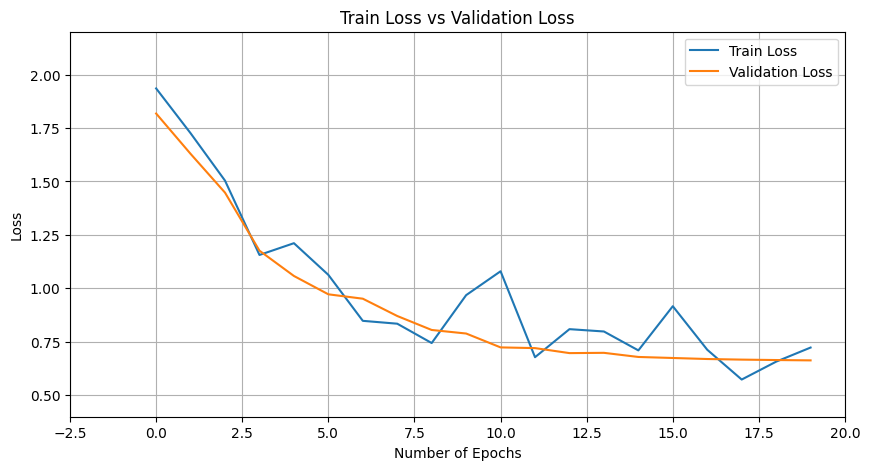

In [24]:
import matplotlib.pyplot as plt
xc=range(20)
#Extracted from the raw output above using a separate script. Initializa the following variable to the output of the script.
all_loss = [
    {
        "loss": 1.9349,
        "val_loss": 1.8176
    },
    {
        "loss": 1.7254,
        "val_loss": 1.629
    },
    {
        "loss": 1.5037,
        "val_loss": 1.4476
    },
    {
        "loss": 1.1563,
        "val_loss": 1.1763
    },
    {
        "loss": 1.2113,
        "val_loss": 1.0581
    },
    {
        "loss": 1.0632,
        "val_loss": 0.9723
    },
    {
        "loss": 0.8483,
        "val_loss": 0.9518
    },
    {
        "loss": 0.8349,
        "val_loss": 0.8709
    },
    {
        "loss": 0.7445,
        "val_loss": 0.8056
    },
    {
        "loss": 0.9684,
        "val_loss": 0.789
    },
    {
        "loss": 1.0801,
        "val_loss": 0.7241
    },
    {
        "loss": 0.6783,
        "val_loss": 0.7208
    },
    {
        "loss": 0.8094,
        "val_loss": 0.6974
    },
    {
        "loss": 0.7985,
        "val_loss": 0.6987
    },
    {
        "loss": 0.7101,
        "val_loss": 0.6794
    },
    {
        "loss": 0.9167,
        "val_loss": 0.6746
    },
    {
        "loss": 0.7131,
        "val_loss": 0.6698
    },
    {
        "loss": 0.5738,
        "val_loss": 0.667
    },
    {
        "loss": 0.6574,
        "val_loss": 0.665
    },
    {
        "loss": 0.7234,
        "val_loss": 0.6634
    }
]
train_loss = [x['loss'] for x in all_loss]
val_loss = [x['val_loss'] for x in all_loss]
plt.figure(1,figsize=(10,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.grid(True)
plt.legend(['Train Loss','Validation Loss'])
plt.style.use(['classic'])

Check the model summary

In [13]:
model.summary()

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  15092016  
                                                                 
 class_net/class-predict (Se  multiple                 6066      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 10116     
 bleConv2D)                                                      
                                                                 
Total params: 15,108,198
Trainable params: 14,952,694
Non-trainable params: 155,504
_________________________________________________________________


### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 10 images in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [7]:
model.evaluate(test_data)

2024-02-13 20:33:57.757859: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/1 [==============================] - 11s 11s/step



{'AP': 0.35949814,
 'AP50': 0.6780121,
 'AP75': 0.3366957,
 'APs': -1.0,
 'APm': 0.33017433,
 'APl': 0.3890204,
 'ARmax1': 0.045121953,
 'ARmax10': 0.28170732,
 'ARmax100': 0.48536587,
 'ARs': -1.0,
 'ARm': 0.4,
 'ARl': 0.5346154,
 'AP_/car': 0.35949814,
 'AP_/truck': -1.0}

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on final web application.

In [14]:
model.export(export_dir='.', tflite_filename='cars.tflite')

2024-01-24 15:14:28.085804: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2024-01-24 15:15:29.935448: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-01-24 15:15:47.470373: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-01-24 15:15:47.470443: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-01-24 15:15:47.497480: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/tmp/tmpqi9gh5ae
2024-01-24 15:15:47.929757: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-01-24 15:15:47.929845: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if

### Step 6:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [15]:
model.evaluate_tflite('cars.tflite', test_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


6/6 [==============================] - 339s 56s/step



{'AP': 0.34211466,
 'AP50': 0.61310863,
 'AP75': 0.32183418,
 'APs': -1.0,
 'APm': 0.23088543,
 'APl': 0.41351926,
 'ARmax1': 0.05121951,
 'ARmax10': 0.297561,
 'ARmax100': 0.4402439,
 'ARs': -1.0,
 'ARm': 0.28,
 'ARl': 0.5326923,
 'AP_/car': 0.34211466,
 'AP_/truck': -1.0}

## Test the car detection model

After training the model, let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

In [3]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


Detection latency: 29.204378843307495s


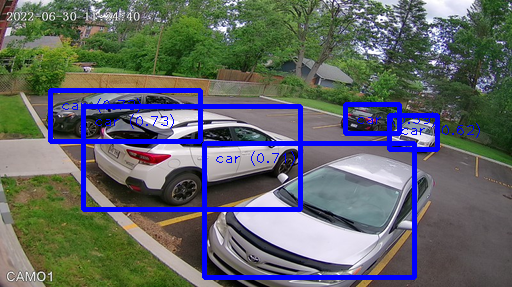

In [6]:
#@title Run object detection and show the detection results

from PIL import Image
import time

INPUT_IMAGE_URL = "images/test/Montreal_2022-6-30_17h0m.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}
TFLITE_MODEL_PATH = "model.tflite" #@param {type:"string"}

TEMP_FILE = '/tmp/image.png'

#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
image = Image.open(INPUT_IMAGE_URL).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
start = time.time()
detections = detector.detect(image_np)
end = time.time()
print(f'Detection latency: {end-start}s')

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)